# Introduction

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

dataset_path = '/home/paolo/PycharmProjects/backtesting_experiments/data/HistoricalData_NG.csv'
weekly_lower_dataset = '/home/paolo/PycharmProjects/backtesting_experiments/data/Weekly_Lower_48_States_Natural_Gas_Working_Underground_Storage_Weekly.csv'
us_gross_withdrawal_dataset = '/home/paolo/PycharmProjects/backtesting_experiments/data/U.S._Natural_Gas_Gross_Withdrawals_Monthly.csv'
o_gross_withdrawals_dataset = '/home/paolo/PycharmProjects/backtesting_experiments/data/Other_States_Natural_Gas_Gross_Withdrawals_Monthly.csv'
consumption = '/home/paolo/PycharmProjects/backtesting_experiments/data/U.S._Natural_Gas_Total_Consumption_Monthly.csv'

,Close,Volume,Open,High,Low
Date,,,,,
2021-08-30,4.305,161299.0,4.499,4.526,4.222
2021-08-27,4.370,3899.0,4.202,4.397,4.197
2021-08-26,4.184,64362.0,3.917,4.217,3.896
2021-08-25,3.897,37979.0,3.900,3.991,3.858
2021-08-24,3.896,54557.0,3.929,3.970,3.884
...,...,...,...,...,...
2011-09-07,3.940,142394.0,3.925,4.038,3.900
2011-09-06,3.938,99262.0,3.920,3.950,3.856
2011-09-02,3.872,121067.0,4.050,4.058,3.850


In [ ]:
data = pd.read_csv(dataset_path, sep=',', index_col=0, parse_dates=True)
data = data.dropna()

data

# NG!

Let's first start to decompose the Natural Futures Price data and see what we'll obtain from it.

# Trend Component

We simply identify the trend component by using a simple 21-period moving average.

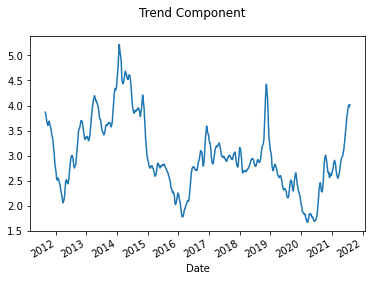

In [3]:
data['SMA_21'] = data.Close.rolling(21).mean()

fig = plt.figure()

fig.suptitle('Trend Component')

data['SMA_21'].plot()

plt.show()

# Seasonality and Noise Component

Assuming that the effect of seasonality is multiplicative we simply obtain the seasonal and noise components just by
dividing the Close prices by the trend component.

In [4]:
data['S_N'] = data.Close / data['SMA_21']

fig = plt.figure()

fig.suptitle('Seasonality and Noise Component')

data['S_N'].plot()

plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/paolo/PycharmProjects/backtesting_experiments/venv/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/home/paolo/PycharmProjects/backtesting_experiments/venv/lib/python3.8/site-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/paolo/PycharmProjects/backtesting_experiments/venv/lib/python3.8/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "/home/paolo/PycharmProjects/backtesting_experiments/venv/lib/python3.8/site-packages/decorator.py", line 231, in fun
    args, kw = fix(args, kw, sig)
  File "/home/paolo/PycharmProjects/backtesting_experiments/venv/lib/python3.8/site-packages/decorator.py", line 205, in fix
    return ba.args, ba.kwargs
  File "/usr/lib/python3.8/inspect.py", line 2666, in kwargs
    for param_name, param in self._signature.par

TypeError: object of type 'NoneType' has no len()

Now that we have the seasonal and noise component together we can extrapolate the seasonality by
averaging the value of each month of the year.

In [ ]:
import math

data['MONTH'] = data.index.strftime('%m').astype(np.int)

average_seasonal_values = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

average_seasonal_value_counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

for i in range(0, data['S_N'].size):
    if math.isnan(data['S_N'][i]) is False:
        average_seasonal_values[data['MONTH'][i]] = average_seasonal_values[data['MONTH'][i]] + \
            data['S_N'][i]
        average_seasonal_value_counts[data['MONTH'][i]] = \
            average_seasonal_value_counts[data['MONTH'][i]] + 1

for i in range(1, 13):
    average_seasonal_values[i] = average_seasonal_values[i] / average_seasonal_value_counts[i]

data['SEASONALITY'] = np.nan

for i in range(0, data['S_N'].size):
    if math.isnan(data['S_N'][i]) is False:
        data['SEASONALITY'][i] = \
            average_seasonal_values[data['MONTH'][i]]

In [ ]:
fig = plt.figure()

fig.suptitle('The \'pure\' SEASONAL component')

# plt.ylim(0.975, 1.075)
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'))

data['SEASONALITY'].plot()

plt.show()

In [ ]:
fig = plt.figure()

fig.suptitle('Yearly Seasonality')

# plt.ylim(0.975, 1.075)
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-06-01'))

data['SEASONALITY'].plot()

plt.show()

What we have got from the seasonality of the price is pretty intuitive:

- Price of Natural gas are rising in winter, hence we people need the most
- After February prices steadily decline until June
- There is a little increase in the price in the summer months (July, June, August)

# Noise Component

In [ ]:
data['NOISE'] = data['S_N'] / data['SEASONALITY']

fig = plt.figure()

fig.suptitle('Noise Component')

data['NOISE'].plot()

plt.show()

After we've studied the NG future seasonality, let's take a look at some fundamental data such as:

- the weekly lower underground storage
- the world's gross NG withdrawals
- the US's gross NG withdrawals
- the US Natural Gas consumption

# Weekly Lower Underground Storage

In [ ]:
storage_df = pd.read_csv(weekly_lower_dataset, sep=',', parse_dates=True, index_col=0)
storage_df.rename(columns={'Series ID: NG.NW2_EPG0_SWO_R48_BCF.W Billion Cubic Feet': 'MCF'}, inplace=True)

storage_df

In [ ]:
fig = plt.figure()

fig.suptitle('Weekly Lower 48 States Natural Gas Working Underground Storage Weekly')

storage_df.plot()

plt.show()

Let's first check if the series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data, do_print=False):
    t_stat, p_value, _, _, critical_values, _  = adfuller(data.values, autolag='AIC')

    if do_print:
        print(f'ADF Statistic: {t_stat:.2f}')
        for key, value in critical_values.items():
             print('Critial Values:')
             print(f'   {key}, {value:.2f}')

        print(f'\np-value: {p_value:.2f}')
        print("Non-Stationary") if p_value > 0.05 else print("Stationary")

    return p_value <= 0.05, p_value

In [ ]:
_, _ = check_stationarity(storage_df['MCF'], do_print=True)

The p-value of the adf is very low, so we cannot accept the null hypothesis, hence the series is stationary and it does
not some kind of transformation.

Now let's visualize how the NG future price stagionality found before is related to the NG storage levels.

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(data['SEASONALITY'], color=color)
ax1.set_ylabel('seasonality', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.plot(storage_df, color=color)
ax2.set_ylabel('storage', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-06-01'))

fig.tight_layout()
plt.show()

As we can see the price seasonality peaks almost completely match the lower storage levels of Natual Gas.

# Seasonality of other states natural gas gross withdrawals monthly

In [ ]:
other_withdrawals = pd.read_csv(o_gross_withdrawals_dataset, sep=',', index_col=0, parse_dates=True)
us_withdrawals = pd.read_csv(us_gross_withdrawal_dataset, sep=',', index_col=0, parse_dates=True)
other_withdrawals.rename(columns={'Series ID: NG.N9010982.M Million Cubic Feet':'MCF'}, inplace=True)
us_withdrawals.rename(columns={'Series ID: NG.N9010US2.M Million Cubic Feet':'MCF'}, inplace=True)
us_withdrawals = us_withdrawals.dropna()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

o_components = seasonal_decompose(other_withdrawals, model='multiplicative')

In [ ]:
ts = (other_withdrawals
      .assign(Trend=o_components.trend)
      .assign(Seasonality=o_components.seasonal)
      .assign(Residual=o_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

In [ ]:

fig = plt.figure()

fig.suptitle('Others withdrawals Seasonal Component')

o_components.seasonal.plot()

plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01'))

plt.show()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(data['SEASONALITY'], color=color)
ax1.set_ylabel('seasonality', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.plot(o_components.seasonal, color=color)
ax2.set_ylabel('Other Gross Withdrawals', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-12-01'))

fig.tight_layout()
plt.show()

# Seasonality of US states natural gas gross withdrawals monthly

In [ ]:
us_components = seasonal_decompose(us_withdrawals, model='multiplicative')

In [ ]:
ts = (us_withdrawals
      .assign(Trend=us_components.trend)
      .assign(Seasonality=us_components.seasonal)
      .assign(Residual=us_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

In [ ]:

fig = plt.figure()

fig.suptitle('Us withdrawals Seasonal Component')

us_components.seasonal.plot()

plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01'))

plt.show()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(data['SEASONALITY'], color=color)
ax1.set_ylabel('seasonality', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.plot(us_components.seasonal, color=color)
ax2.set_ylabel('US Gross Withdrawals', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.tick_params(axis="x", rotation=50, colors='white')

plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-12-01'))

fig.tight_layout()
plt.show()

# Consumptions

In [ ]:
consumption_data = pd.read_csv(consumption, sep=',', index_col=0, parse_dates=True)

In [ ]:
fig = plt.figure()

fig.suptitle('US NG Consumption')

consumption_data.plot()

plt.show()

In [ ]:
consumption_components = seasonal_decompose(consumption_data, model='multiplicative')

cons_ts = (consumption_data
      .assign(Trend=consumption_components.trend)
      .assign(Seasonality=consumption_components.seasonal)
      .assign(Residual=consumption_components.resid))

with sns.axes_style('white'):
    cons_ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

In [ ]:
fig = plt.figure(figsize=(14, 8))

fig.suptitle('Us Consumption Seasonal Component')

consumption_components.seasonal.plot()

plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2020-12-01'))

plt.show()

The seasonal pattern of the US NG Consumptions make perfect sense: consumption rises in winter months and
decreases in summer months, with a little increase in july and august (which is probably due to the use of air conditioning).


In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(data['SEASONALITY'], color=color)
ax1.set_ylabel('seasonality', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.plot(consumption_components.seasonal, color=color)
ax2.set_ylabel('consumption', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-12-01'))

ax1.tick_params(axis="x", rotation=50, colors='white')

fig.tight_layout()
plt.show()

By overlapping the two series, we can notice (again) that the price seasonality is matching the consumption seasonality.

After seeing how the seasonality of the NG future price is related to the seasonality of its fundamentals, a natural question that may be risen is: Can we build a profitable trading strategy that leverages the seasonality of Natural Gas?

Let's try to answer this question by backtesting it.

Possiamo costruire un strategia di trading che sia basa sulla stagionalità??

- Backtest buy sep sell jan
- Backtest idea contraria (siccome i mercati tendono ad anticipare)
- Backtest usando strategia con qualche fun approx.